---
TUNING A CLASSIFIER
---
     With scikit-learn, tuning a classifier for recall can be achieved in (at least) two main steps.
    1. Using GridSearchCV to tune your model by searching for the best hyperparameters and keeping the classifier with the highest recall score.
    2. Adjust the decision threshold using the precision-recall curve and the roc curve, which is a more involved method that I will walk through
    
    
    https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC
#from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import roc_auc_score
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


from matplotlib.colors import ListedColormap

#from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree
#from adspy_shared_utilities import plot_class_regions_for_classifier
#from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
#from adspy_shared_utilities import plot_fruit_knn

In [2]:
plt.style.use("ggplot")

---
BREAST CANCER DATASET
---

In [3]:
from sklearn.datasets import load_breast_cancer
# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)
print ("Type of data structure: ", type(cancer))
print ("Keys: ", cancer.keys())
print ("Feature names: ", cancer["feature_names"])

# convert to dataframe
cancerdf = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancerdf['target'] = pd.Series(cancer.target)
counts = cancerdf.target.value_counts(ascending=True)
counts.index = "malignant benign".split()
print ("Distribution of labelled samples: ")
print(counts)
print ("-------------------------------------------")
#print (cancerdf.head(5))

Type of data structure:  <class 'sklearn.utils.Bunch'>
Keys:  dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Feature names:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Distribution of labelled samples: 
malignant    212
benign       357
Name: target, dtype: int64
-------------------------------------------


In [4]:
from sklearn.metrics import SCORERS
print(sorted(list(SCORERS.keys())))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [5]:
#df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

targets = cancerdf['target']
X_train, X_test, y_train, y_test = train_test_split(cancerdf, 
                                                    targets, 
                                                    train_size = .8, # defaults to .25
                                                    stratify=targets,# consistent class distribution between train and test sets 
                                                    random_state = 0)

print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
1    0.626374
0    0.373626
Name: target, dtype: float64
y_test class distribution
1    0.631579
0    0.368421
Name: target, dtype: float64


First strategy: Optimize for sensitivity using GridSearchCV with the scoring argument.
---
    1. build a generic classifier 
    2. setup a parameter grid; (all tunable parameters eligible to be included in the param grid)
    3. GridSearchCV
    
    The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided

In [12]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    #'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300, 500, 1000],
    #'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20, 30]
}

scorers = {
    'precision_score': make_scorer(precision_score), # limit the number of false positives
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [13]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, 
                               param_grid, 
                               scoring=scorers, 
                               refit=refit_score,
                               cv=skf, 
                               return_train_score=True, 
                               n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [14]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_features': 5, 'n_estimators': 500}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        42         0
pos         0        72


In [15]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 
         'mean_test_recall_score', 
         'mean_test_accuracy_score', 
         #'param_max_depth', 
         'param_max_features', 
         #'param_min_samples_split', 
         'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_features,param_n_estimators
10,1.0,1.0,1.0,10,500
11,1.0,1.0,1.0,10,1000
18,1.0,1.0,1.0,30,500
17,1.0,1.0,1.0,30,300
16,1.0,1.0,1.0,30,100


    Ideally, when designing a cancer diagnosis test, the classifier should strive as few false negatives as possible

In [16]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 
         'mean_test_recall_score', 
         'mean_test_accuracy_score', 
         #'param_max_depth', 
         'param_max_features', 
         #'param_min_samples_split', 
         'param_n_estimators']].round(3).head()

Best params for recall_score
{'max_features': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg        42         0
pos         0        72


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_features,param_n_estimators
10,1.0,1.0,1.0,10,500
11,1.0,1.0,1.0,10,1000
18,1.0,1.0,1.0,30,500
17,1.0,1.0,1.0,30,300
16,1.0,1.0,1.0,30,100


---
Strategy 2: Adjust the decision threshold to identify the operating point
---
    precision_recall_curve
    roc_curve
    
    Visualize the sensitivity-specificity tradeoff in the classifier
    
    where to set the decision threshold of the model to maximize either sensitivity or specificity

    To make this method generalizable to all classifiers in scikit-learn, know that some classifiers (like RandomForest) use .predict_proba() while others (like SVC) use .decision_function(). The default threshold for RandomForestClassifier is 0.5, so use that as a starting point.

In [17]:
grid_search_clf.predict_proba(X_test)

/Users/corinapostelnicu/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.96666667, 0.03333333],
       [0.99666667, 0.00333333],
       [0.94      , 0.06      ],
       [0.        , 1.        ],
       [0.92333333, 0.07666667],
       [0.01      , 0.99      ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.95333333, 0.04666667],
       [0.        , 1.        ],
       [0.04333333, 0.95666667],
       [0.00666667, 0.99333333],
       [0.09666667, 0.90333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.92333333, 0.07666667],
       [0.        , 1.        ],
       [0.28666667, 0.71333333],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.00333333, 0.99666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.30333333, 0.69666667],
       [0.99333333, 0.00666667],
       [0.14333333, 0.85666667],
       [1.

In [18]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)
y_scores

/Users/corinapostelnicu/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0.03333333, 0.00333333, 0.06      , 1.        , 0.07666667,
       0.99      , 0.        , 1.        , 1.        , 0.        ,
       0.04666667, 1.        , 0.95666667, 0.99333333, 0.90333333,
       0.        , 0.        , 1.        , 0.        , 0.07666667,
       1.        , 0.71333333, 1.        , 1.        , 0.99666667,
       0.        , 0.        , 0.69666667, 0.00666667, 0.85666667,
       0.        , 0.97333333, 0.        , 1.        , 0.99666667,
       1.        , 1.        , 0.00333333, 1.        , 1.        ,
       0.        , 1.        , 0.59333333, 0.70666667, 1.        ,
       0.78333333, 0.84      , 0.80333333, 0.99666667, 1.        ,
       0.        , 0.97333333, 0.00666667, 0.01      , 0.49666667,
       0.98666667, 0.94      , 0.95333333, 0.00333333, 0.        ,
       0.        , 0.99666667, 0.99333333, 0.99333333, 0.99333333,
       1.        , 1.        , 0.91666667, 1.        , 1.        ,
       0.01      , 0.97666667, 0.08333333, 0.98333333, 0.28   

In [19]:
# precision-recall curve for the classifier
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [21]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)


     pred_neg  pred_pos
neg        42         0
pos         0        72


<IPython.core.display.Javascript object>


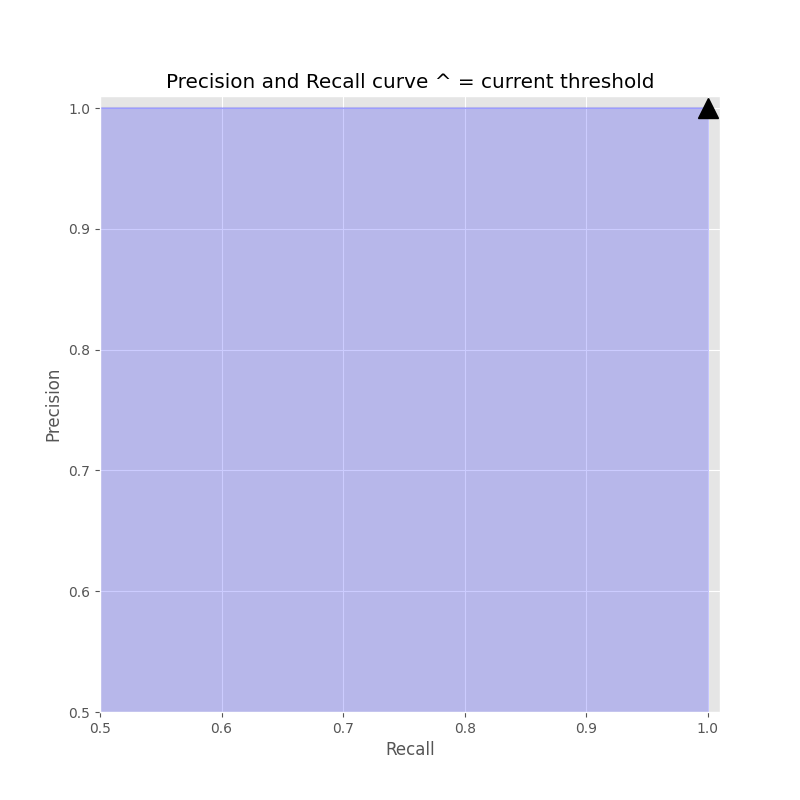

In [27]:
# Re-execute this function for several iterations, changing t each time, 
# to tune the threshold until there are 0 False Negatives

#precision_recall_threshold(p, r, thresholds, 0.30)
precision_recall_threshold(p, r, thresholds, 0.50)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


<IPython.core.display.Javascript object>


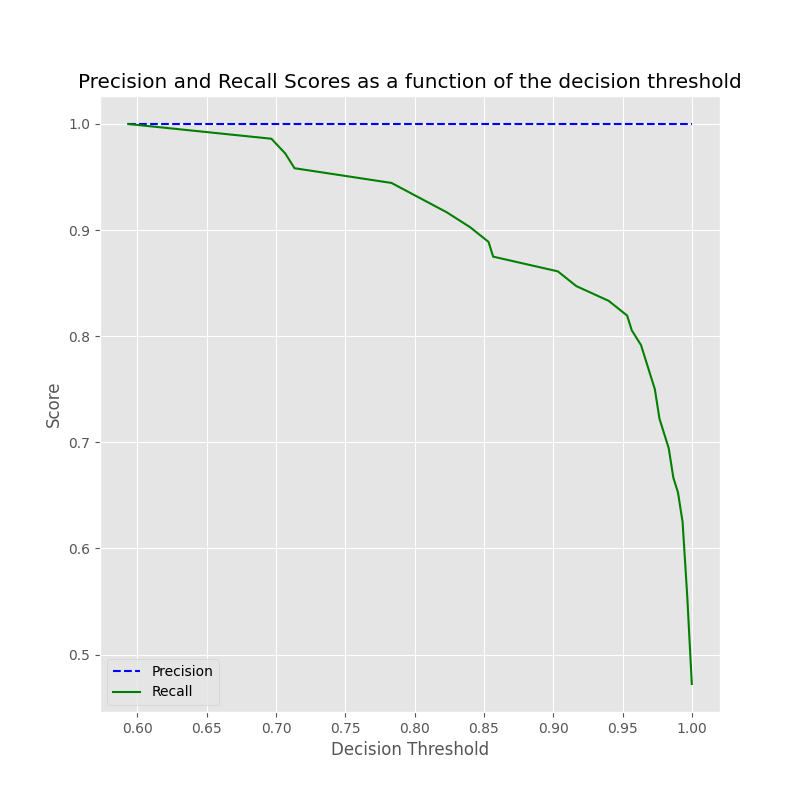

In [30]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

    From the docs, roc_curve: "Note: this implementation is restricted to the binary classification task."

    If label classes (y) are not 0/1 ==> you have to add the pos_label parameter to your roc_curve call.

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

1.0


<IPython.core.display.Javascript object>


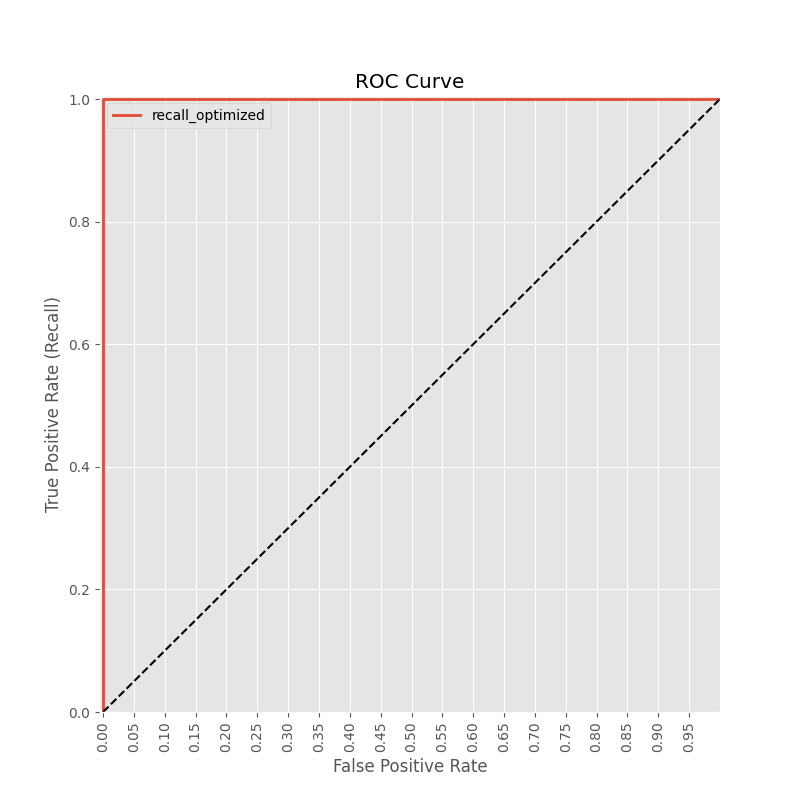

In [32]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')